In [8]:
from sympy import Matrix, S, Rational
from sympy.stats import ContinuousMarkovChain
import numpy as np
import pandas
import gym
from gym import spaces
import numpy as np
import networkx
import pandas as pd
import random
import itertools
import matplotlib.pyplot as plt
import time
import tqdm
from stable_baselines3.common.callbacks import BaseCallback
from IPython import display

# Initialize CTMC

In order to compute the limiting distribution of the CTMC we need to convert the genenrator matrix to an integer matrix (otherwise the library does not work).

In [9]:
P = np.loadtxt('DTMC.csv', delimiter=',', dtype=np.float32)
factor = 100
Q = np.where(P>0.0001, P, 0)
Q = np.divide(np.ones_like(Q), Q, where=Q != 0)
Q[np.diag_indices_from(Q)] = 0
Q = Q.astype(int)
Q[np.diag_indices_from(Q)] = -1 * Q.sum(axis=1) 
G = Matrix([[S(el) for el in row] for row in Q])
ctmc_model = ContinuousMarkovChain('C', state_space=list(range(19*3)), gen_mat=G)

# GYM env

In [10]:
import gym
from gym import spaces
import random

In [11]:
class mRubisCliffEnv(gym.Env):
    def __init__(self, ctmc: np.ndarray, dtmc: np.ndarray, n_states=57):
        self.random = random.Random(None)
        self.observation_space = spaces.Discrete(n_states)
        self.action_space = spaces.Discrete(2)
        self.ctmc = ctmc
        self.dtmc = dtmc
        self.n_states = n_states
        self.correct_reward = 10
        self.incorrect_reward = 0
        print(type(ctmc))

    def step(self, action):
        reward = self.incorrect_reward
        next_observation = self.failed
        if action == 0:
            # Wait
            if self.failed % 3 == 0:
                # Correct
                next_observation = np.random.choice(np.arange(self.n_states), p=self.dtmc[self.failed])
                transition_time = np.random.exponential(1/self.ctmc[self.failed, next_observation])
                reward = self.correct_reward / transition_time
                # reward = self.correct_reward
            else:
                # Incorrect
                pass
        else:
            # Repair
            if self.failed % 3 != 0:
                # Correct
                next_observation = np.random.choice(np.arange(self.n_states), p=self.dtmc[self.failed])
                transition_time = np.random.exponential(1/self.ctmc[self.failed, next_observation])
                reward = self.correct_reward / transition_time
                # reward = self.correct_reward
            else:
                # Incorrect
                pass
        observation = next_observation
        self.failed = next_observation

        terminated = False
        truncated = False
        info = {
            'state': self.failed
        }

        return observation, reward, terminated, info

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.random = random.Random(seed)
        self.generate_observation()

        observation = self.failed
        info = {
            'state': observation
        }
        return observation

    def render(self):
        pass

    def close(self):
        pass

    def generate_observation(self):
        self.failed = random.randint(0, self.n_states - 1)


In [12]:
class Evaluator(BaseCallback):
    def __init__(self, model, env, num_eval_steps=1000, eval_interval=10000, plot_progress=False):
        super().__init__()
        self.total_rewards = []
        self.model = model
        self.env = env
        self.num_eval_steps = num_eval_steps
        self.eval_interval = eval_interval
        self.plot_progress = plot_progress
        self.current_step = 0

    def _on_step(self):
        if self.current_step % self.eval_interval == 0:  
            obs = self.env.reset()
            rewards = []
            for i in range(self.num_eval_steps):
                action, _states = self.model.predict(obs)
                obs, reward, dones, info = self.env.step(action)
                rewards.append(reward)
                if dones:
                    obs = self.env.reset()
            self.total_rewards.append(np.mean(rewards))

            if self.plot_progress:
                display.clear_output(wait=True)
                fig = plt.figure(figsize=(10,5))
                plt.plot(self.total_rewards)
                plt.title(self.model.__class__.__name__)
                plt.xlabel("Training step")
                plt.ylabel("Average reward")
                display.display(fig)
        self.current_step += 1
        return True

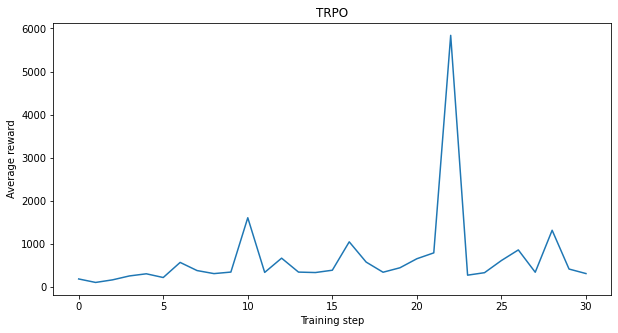

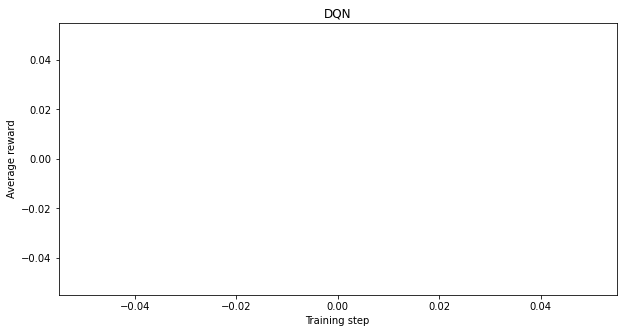

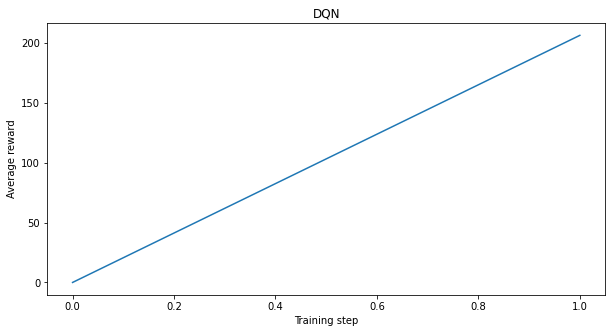

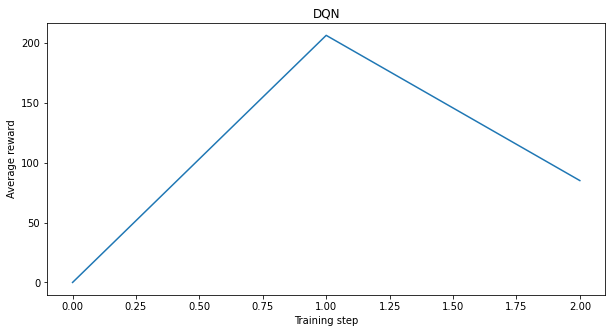

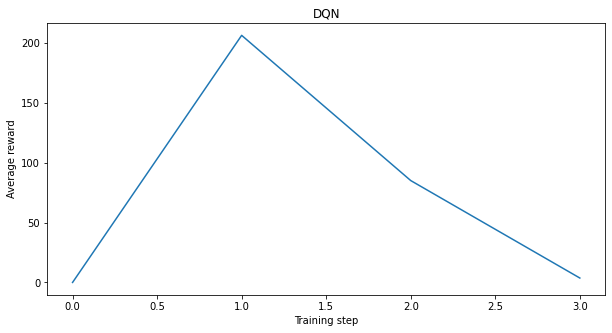

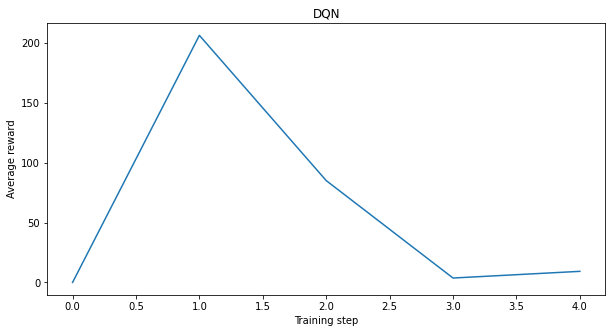

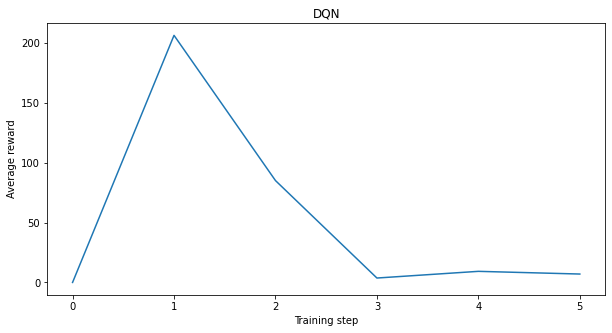

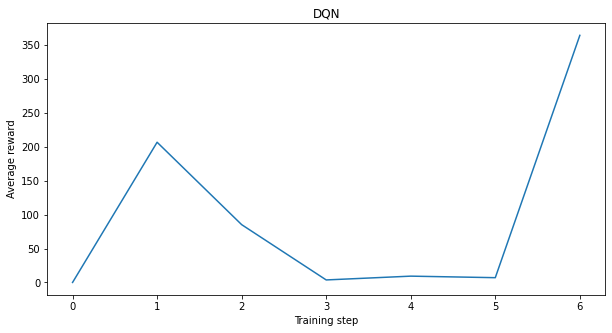

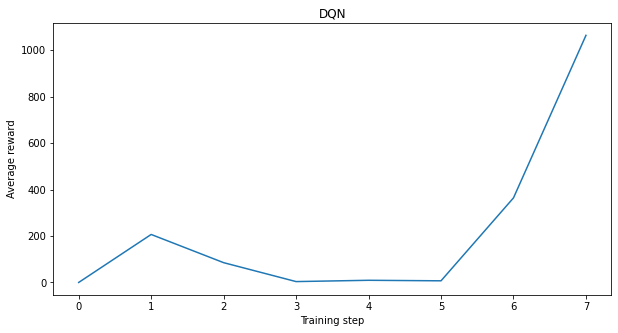

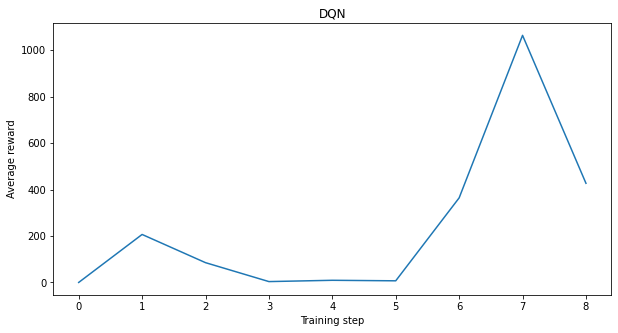

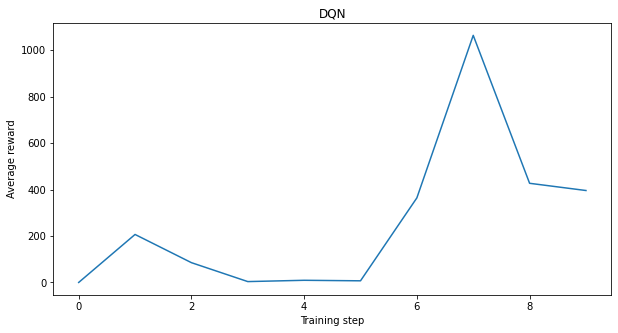

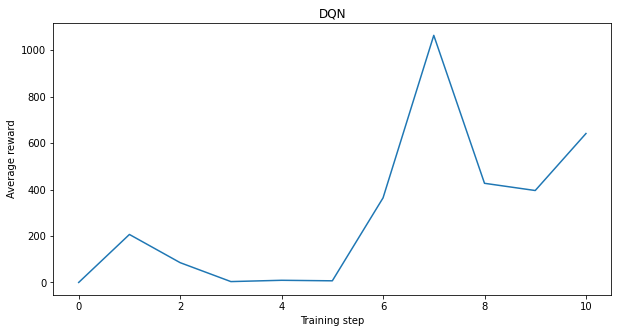

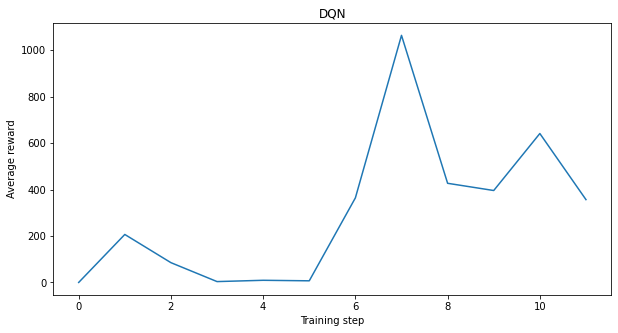

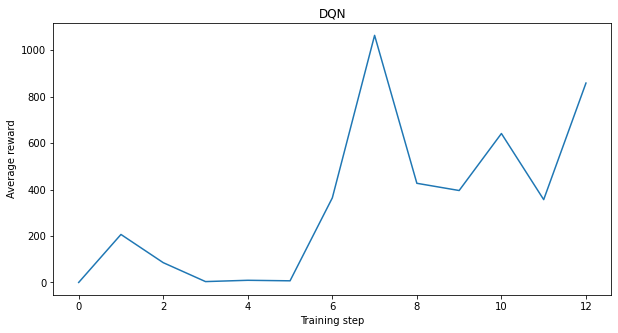

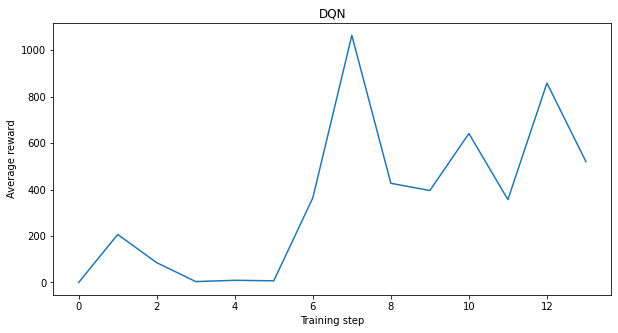

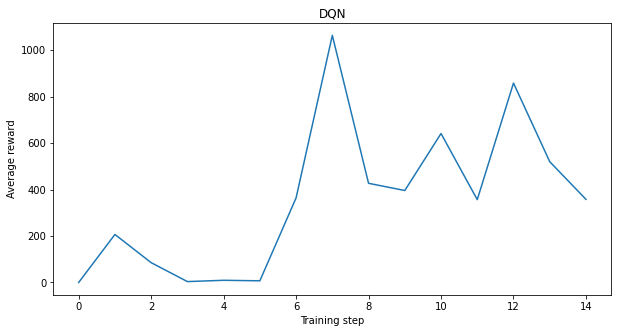

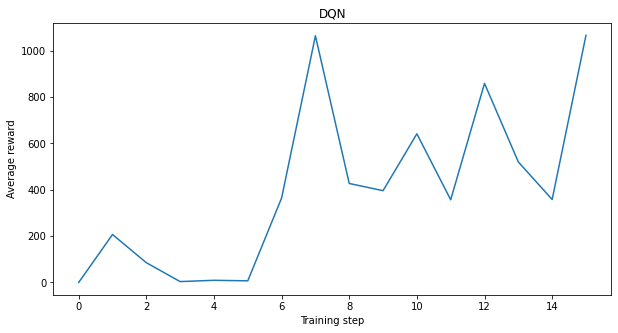

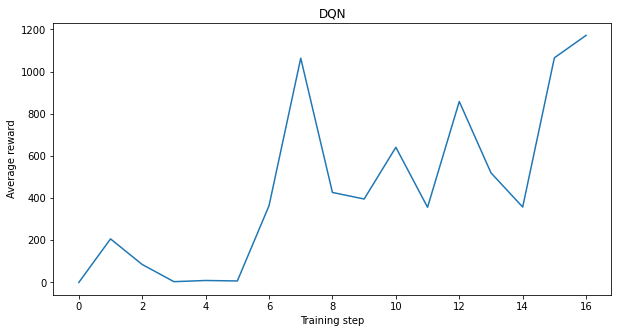

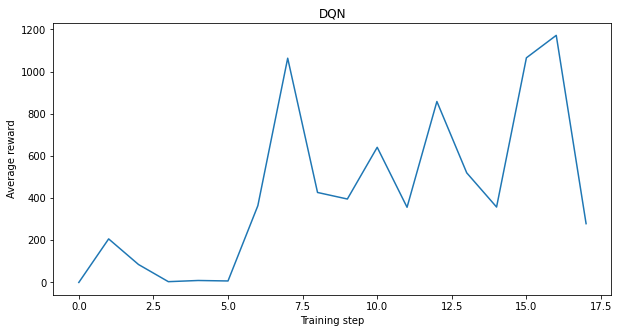

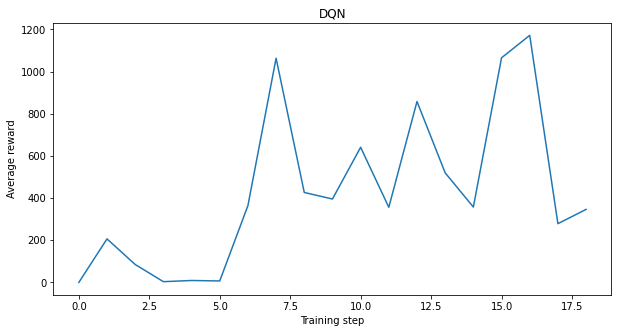

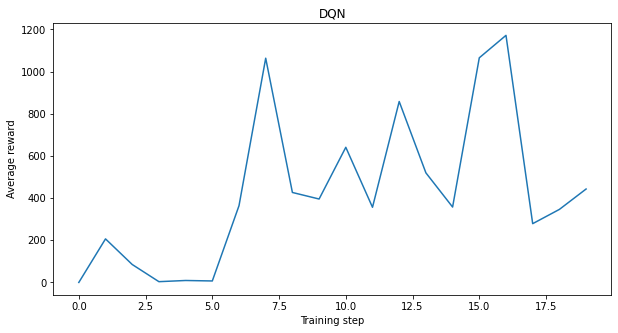

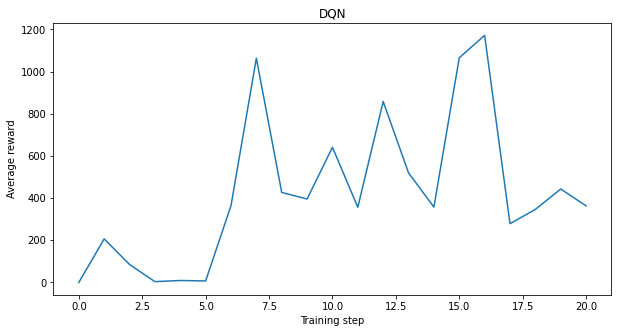

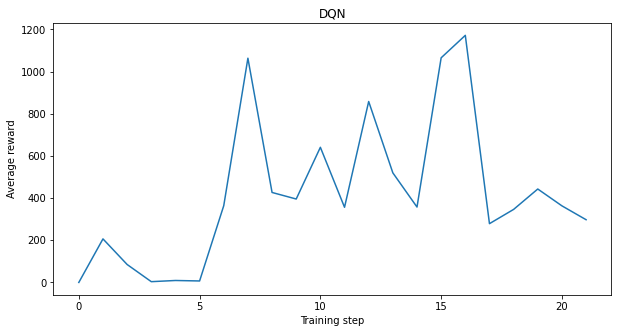

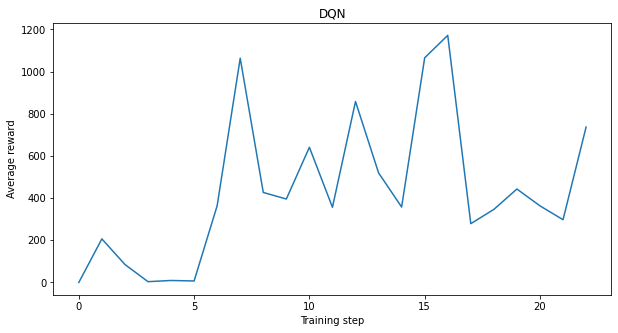

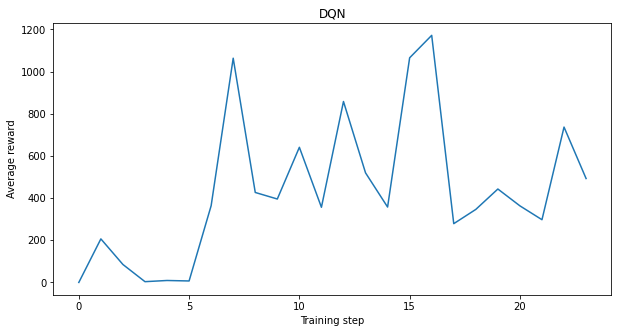

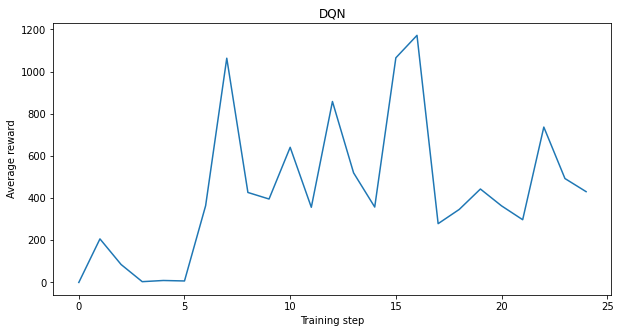

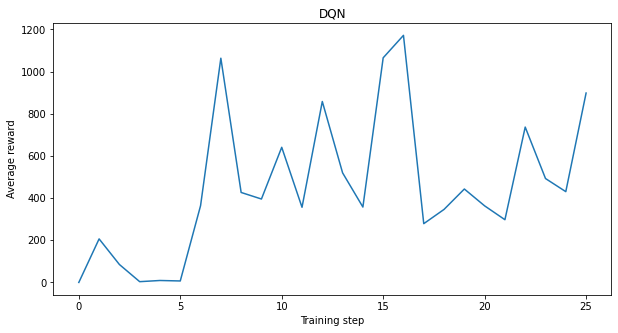

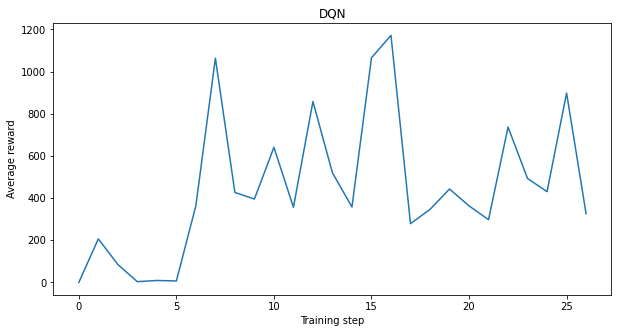

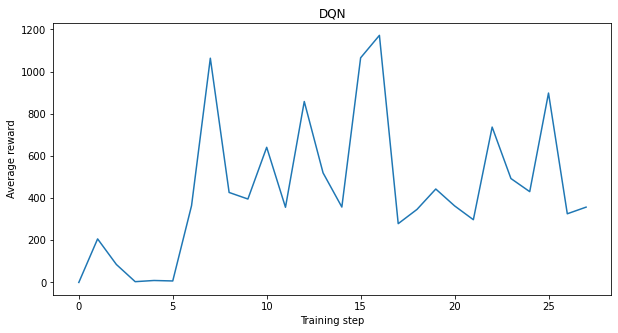

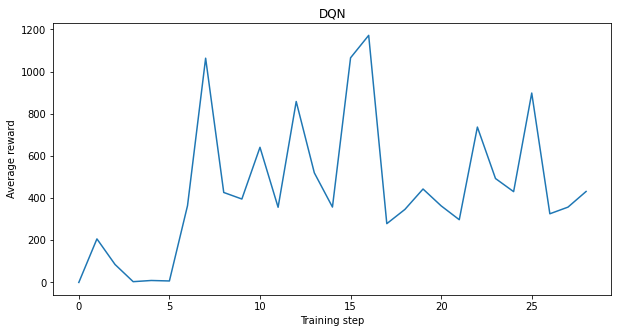

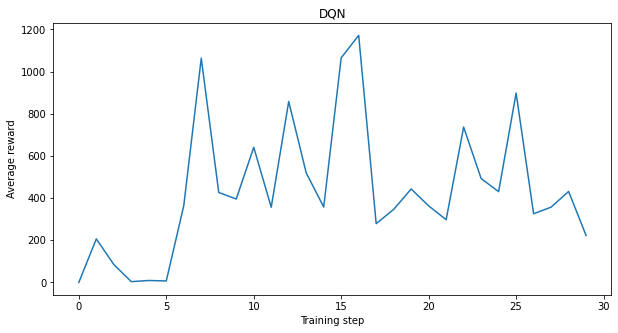

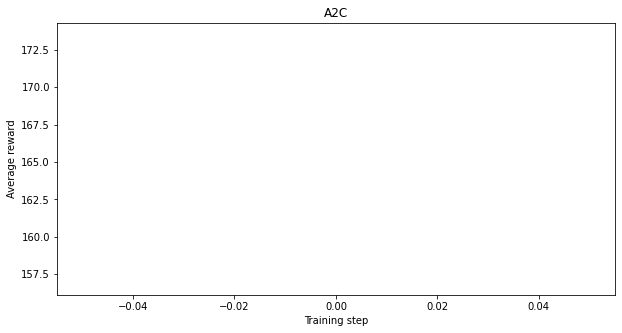

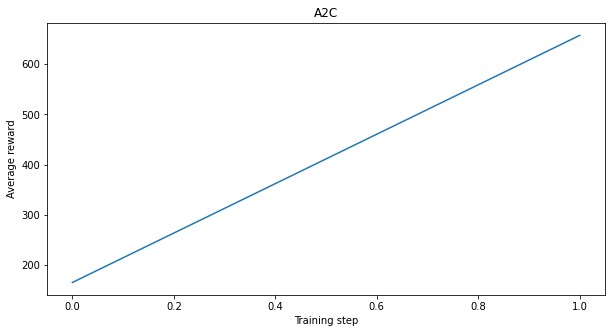

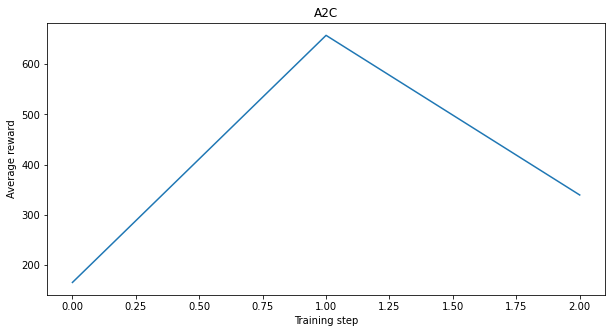

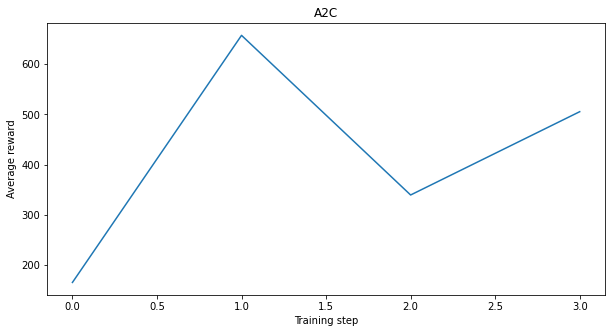

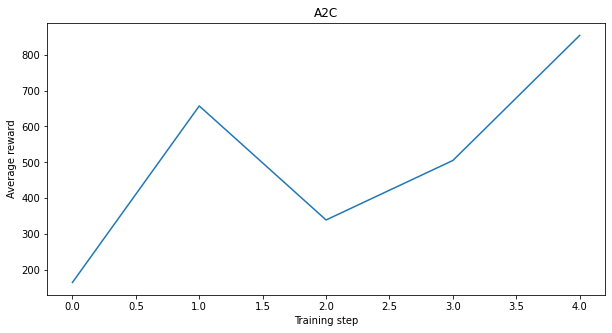

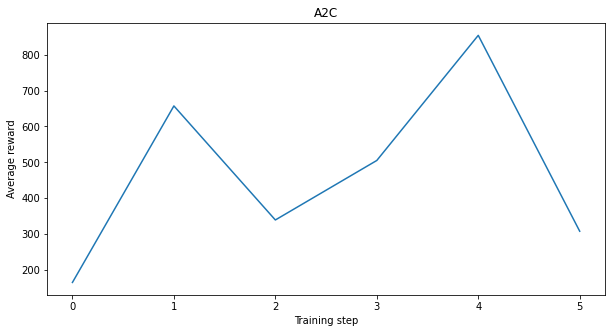

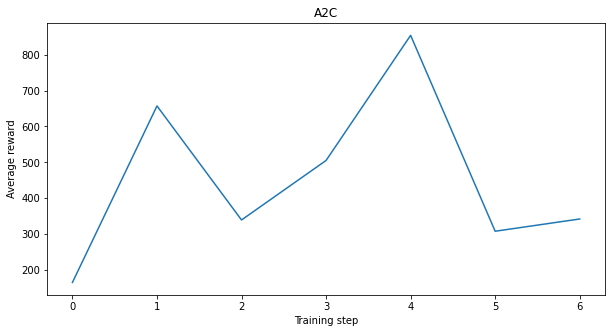

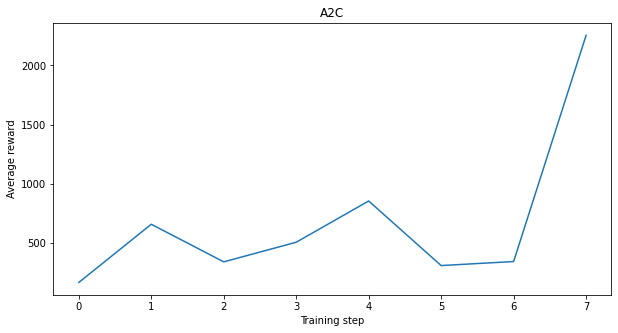

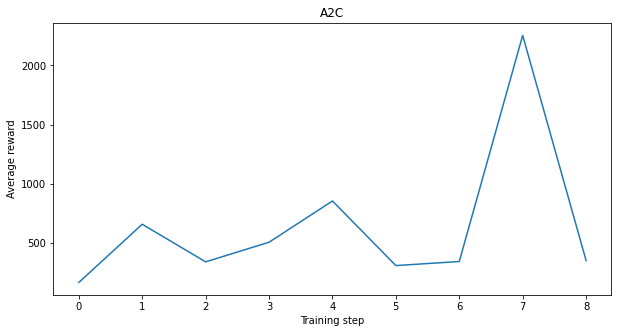

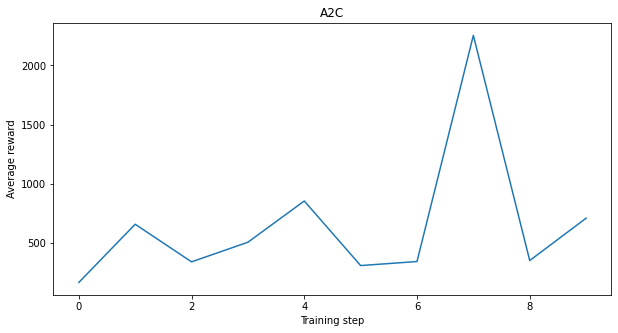

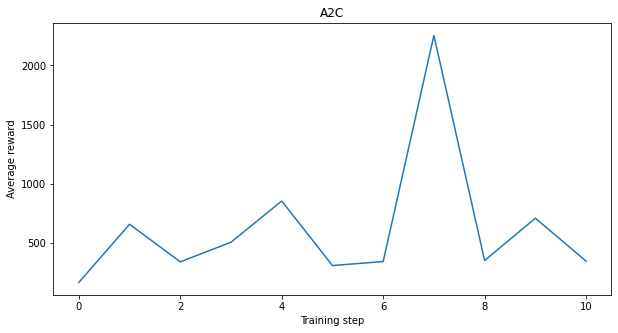

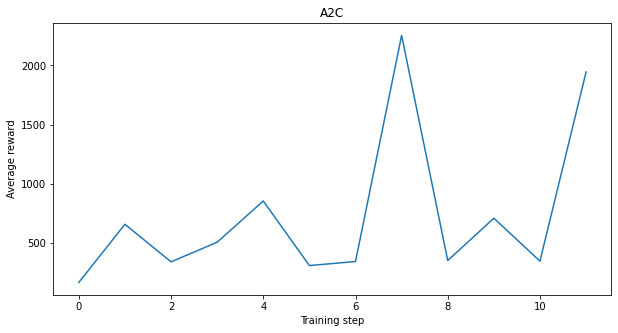

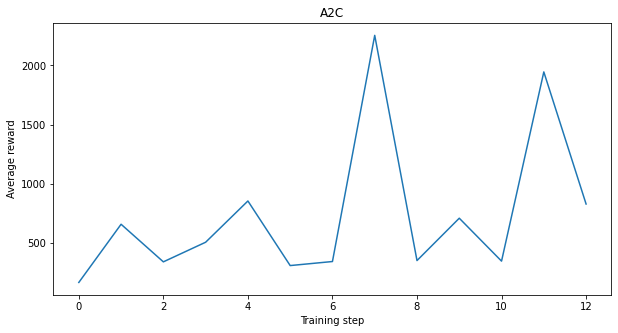

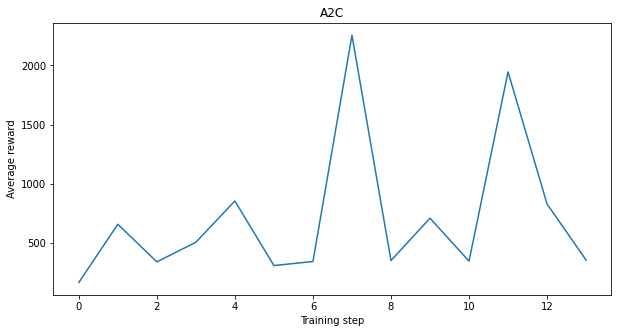

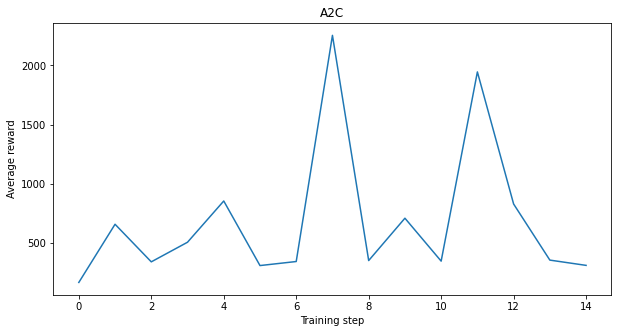

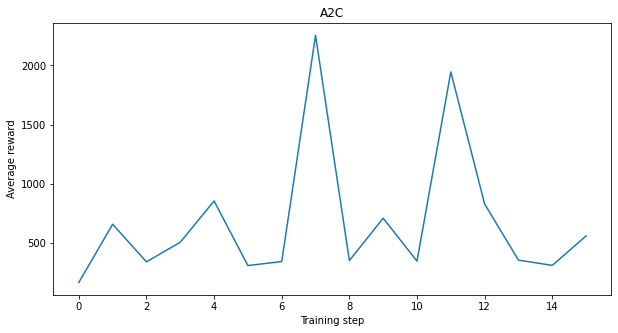

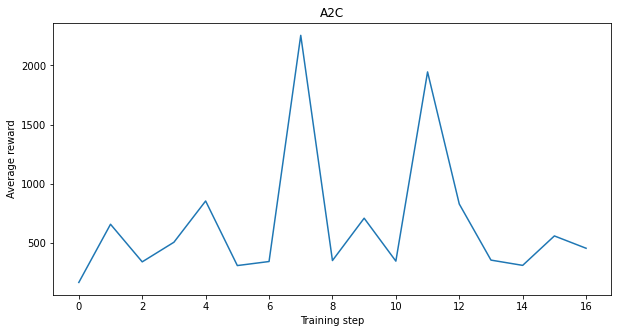

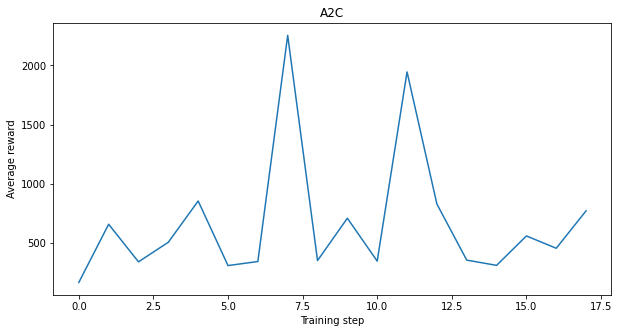

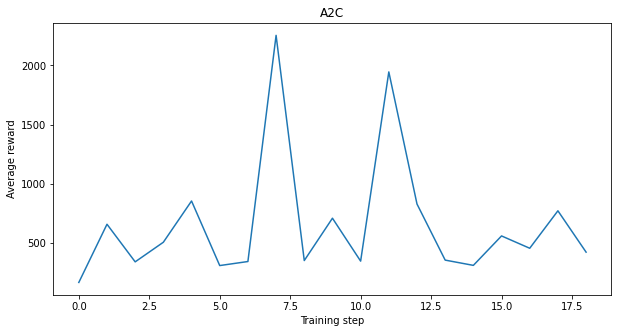

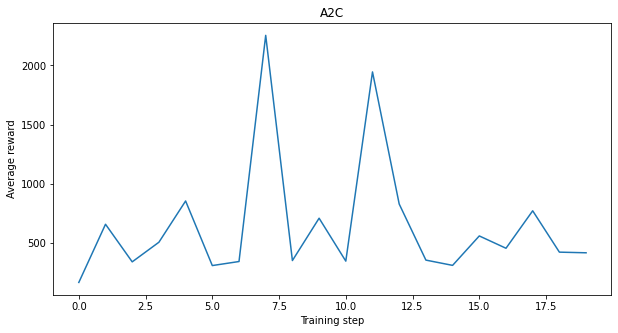

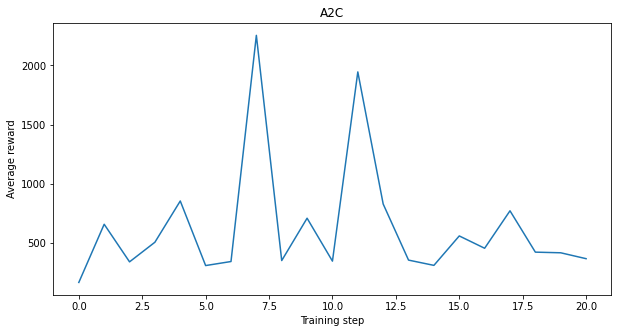

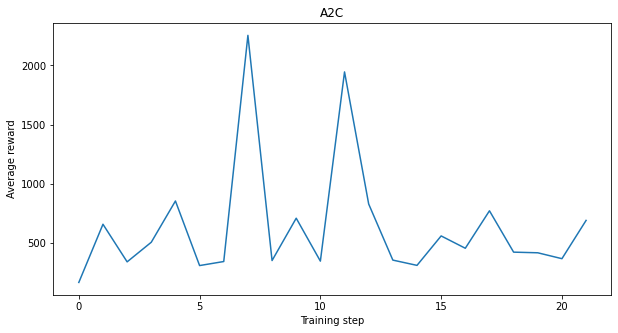

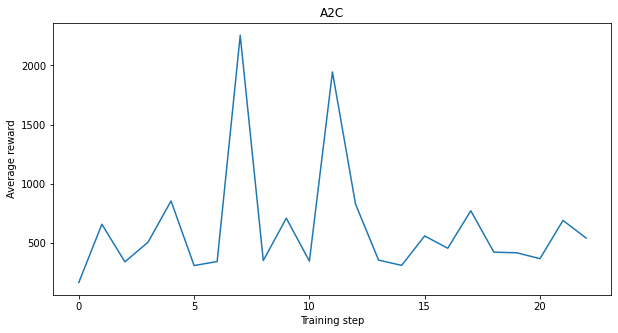

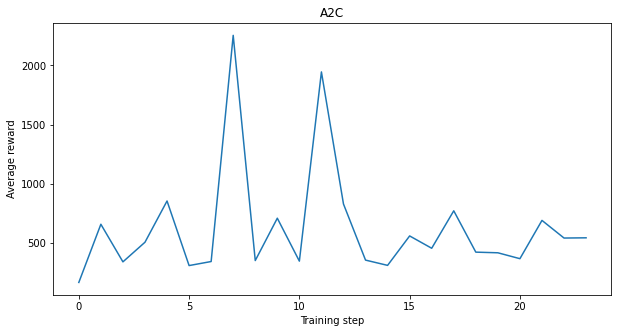

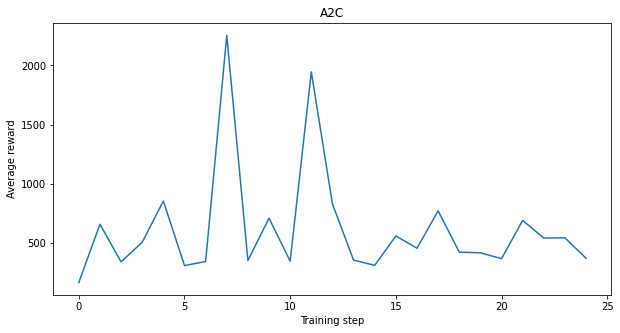

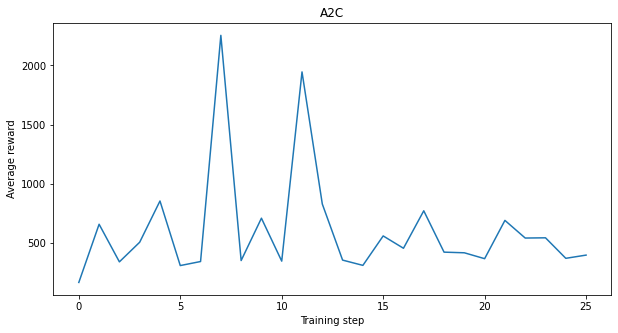

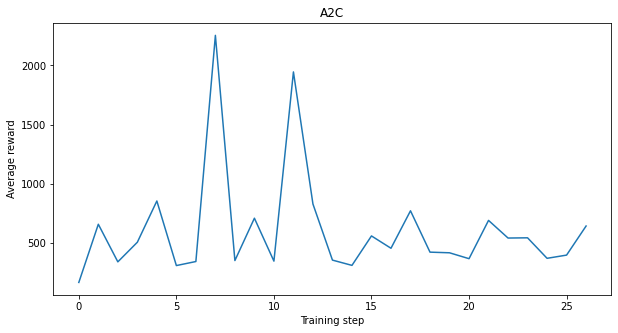

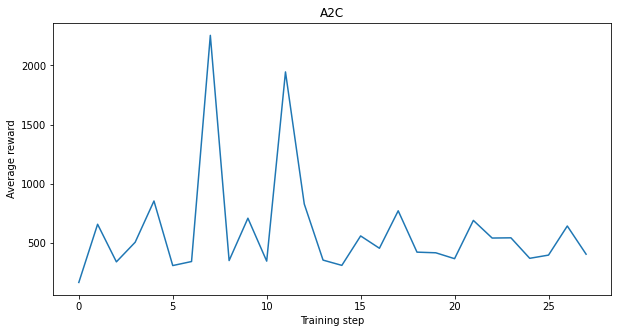

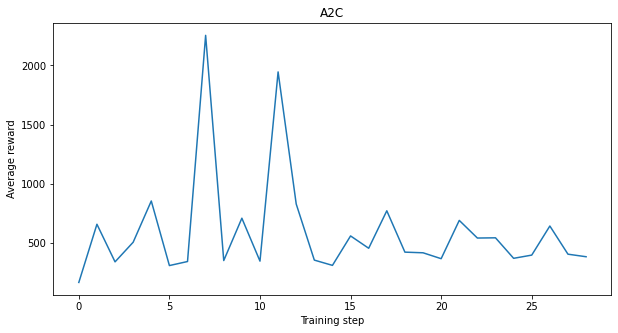

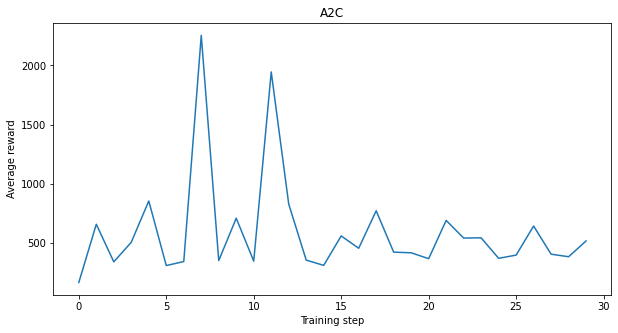

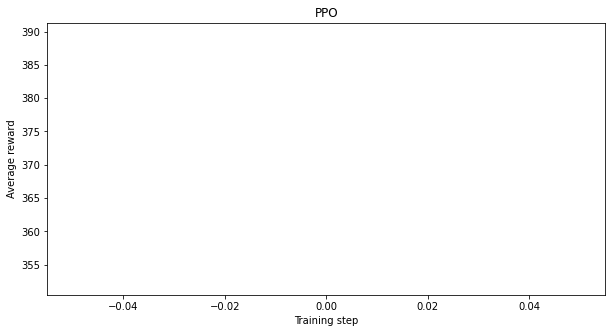

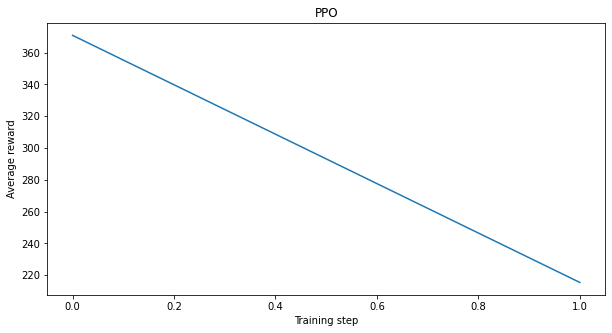

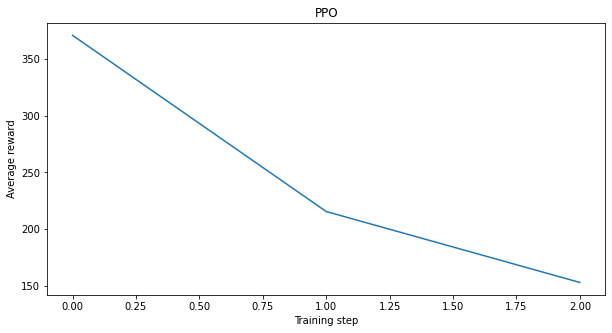

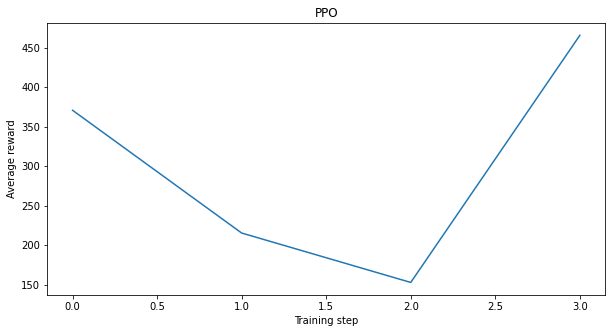

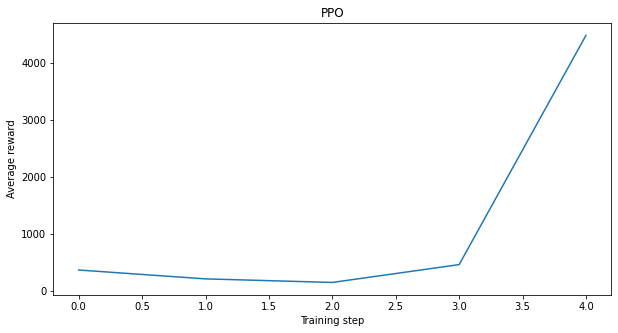

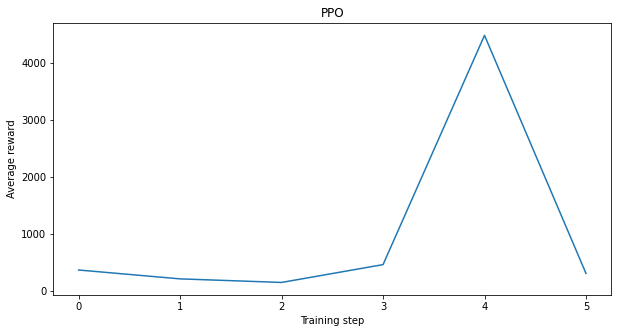

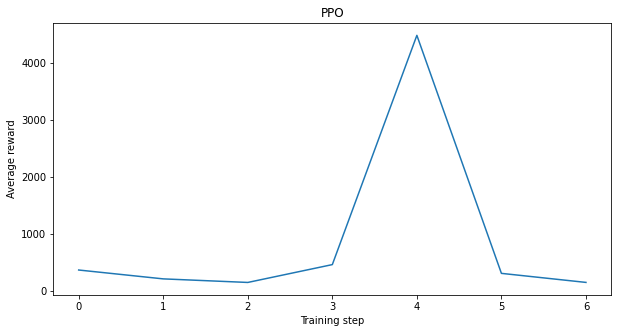

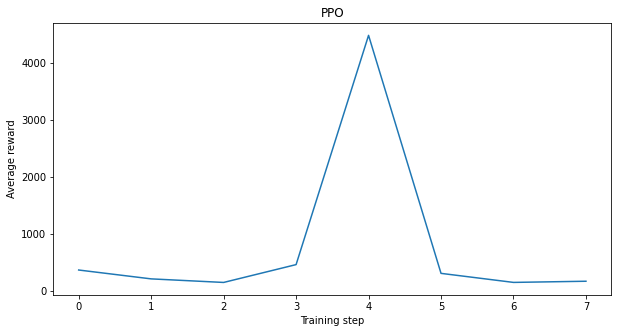

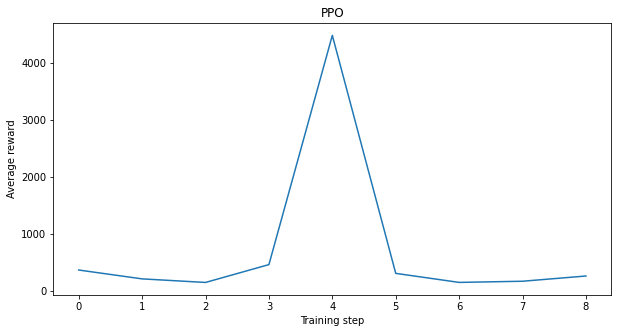

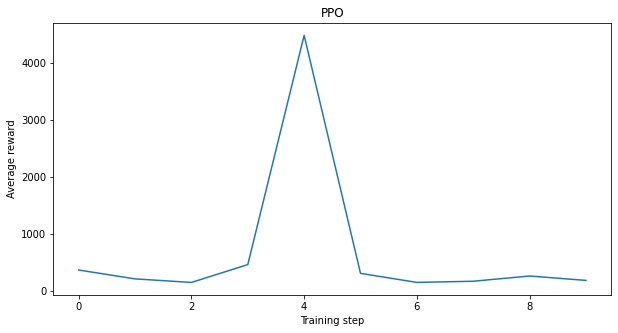

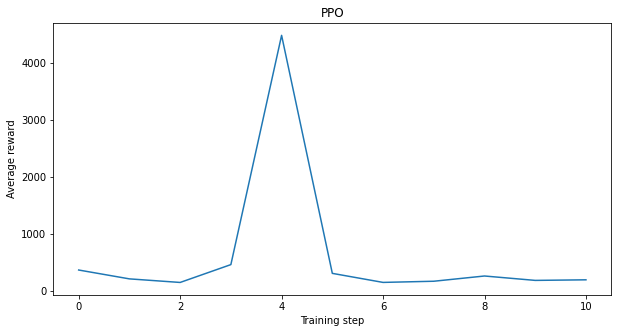

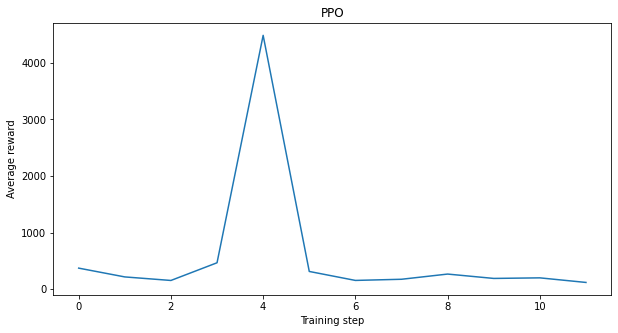

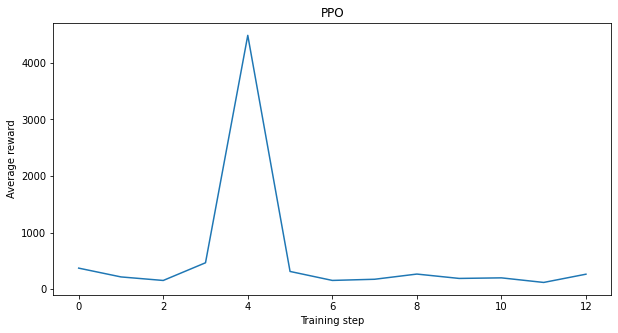

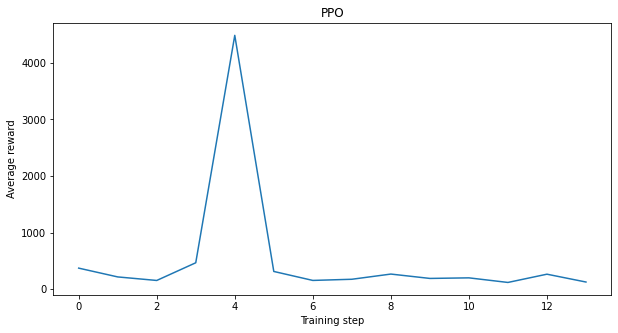

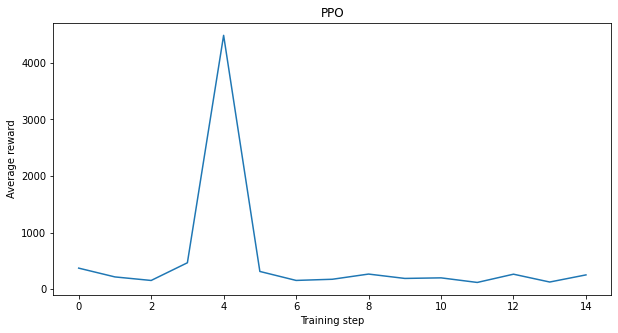

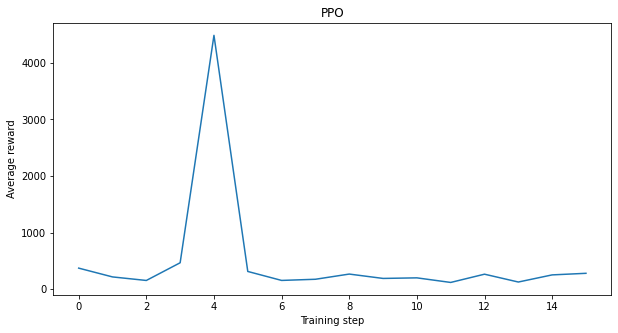

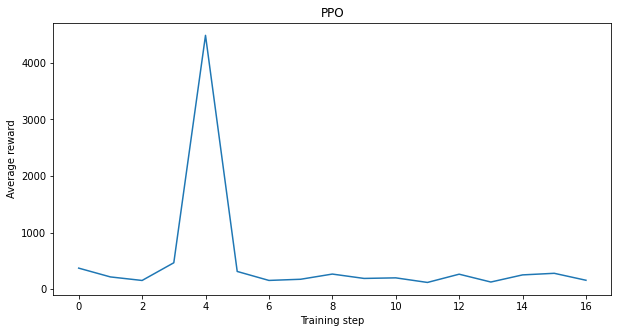

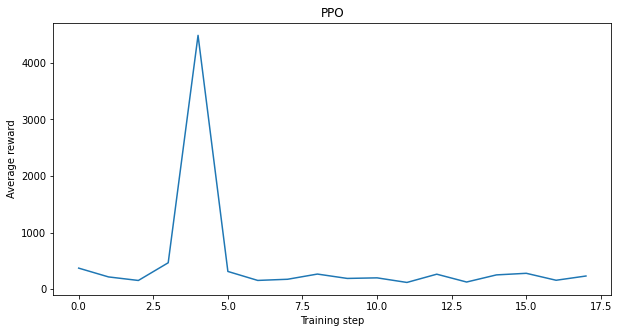

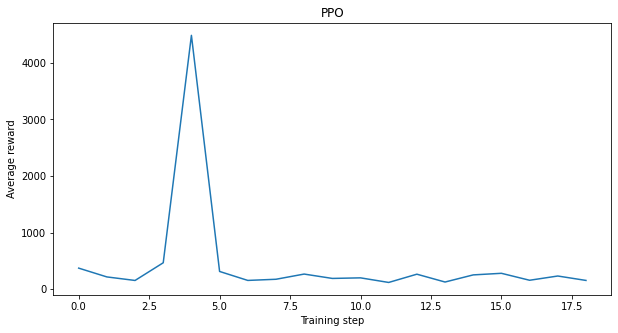

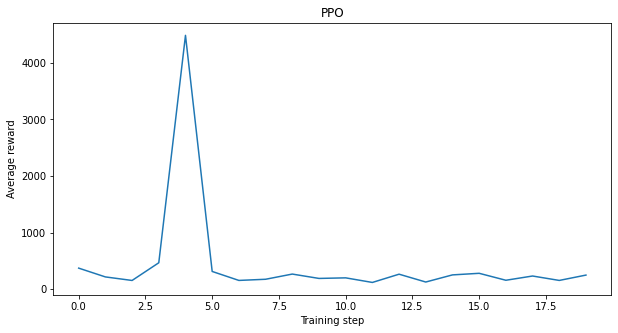

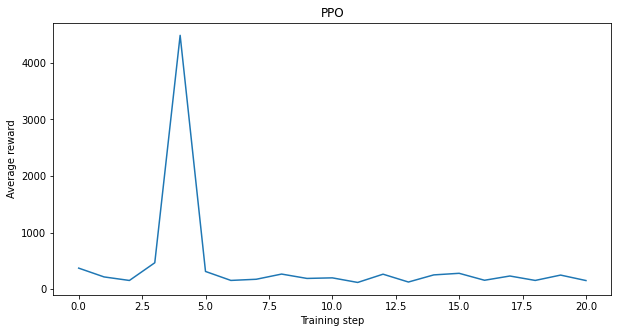

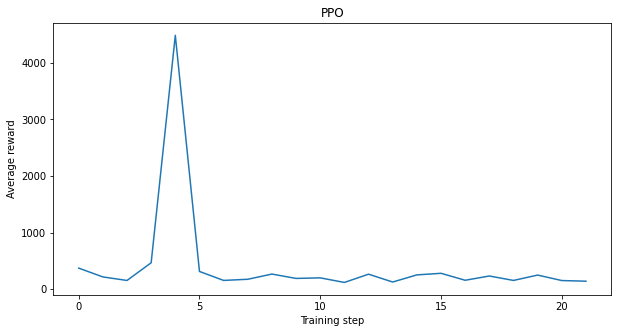

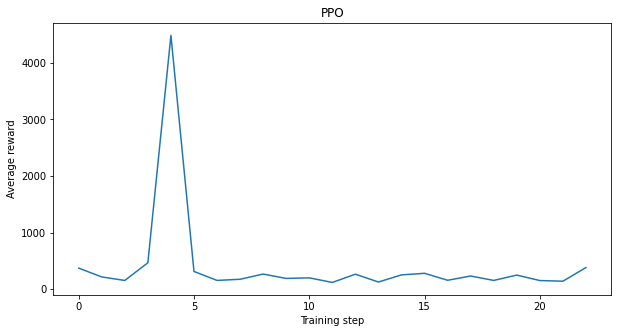

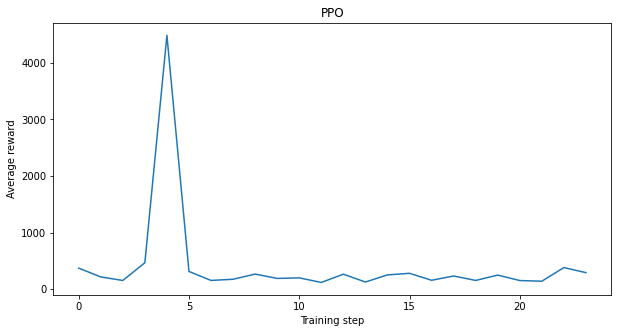

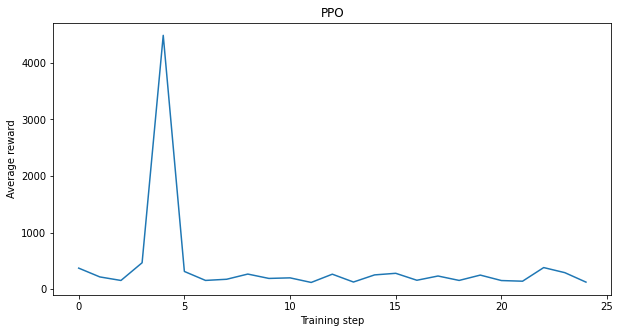

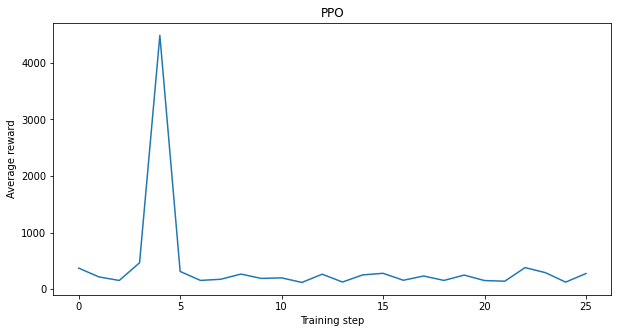

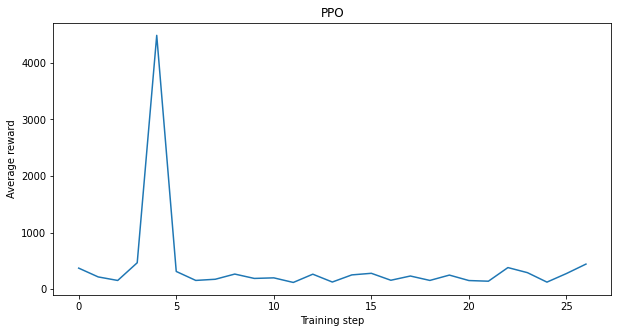

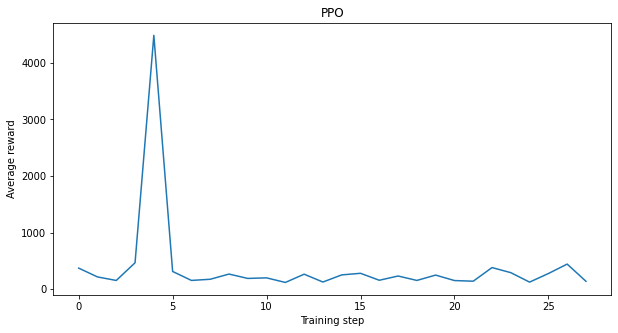

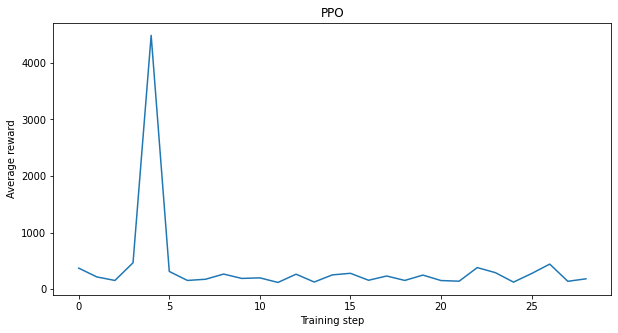

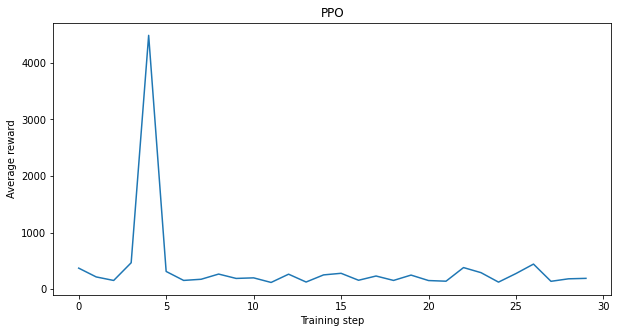

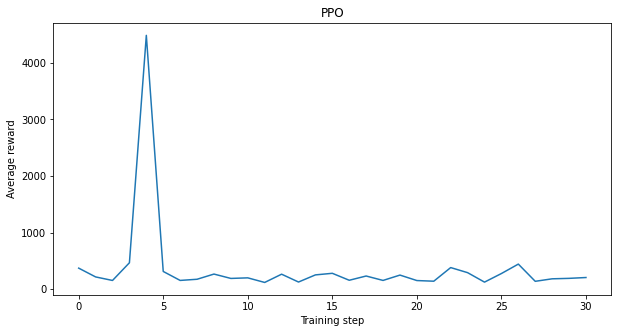

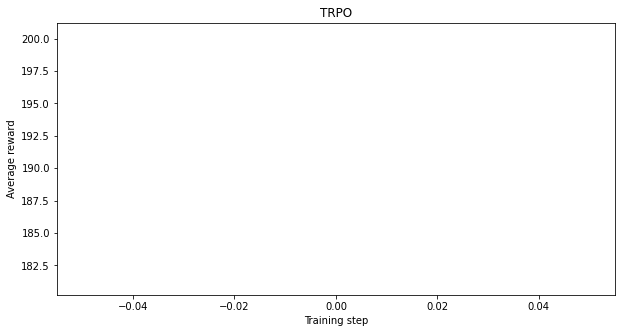

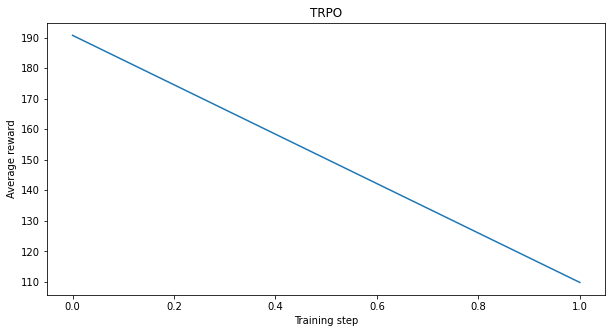

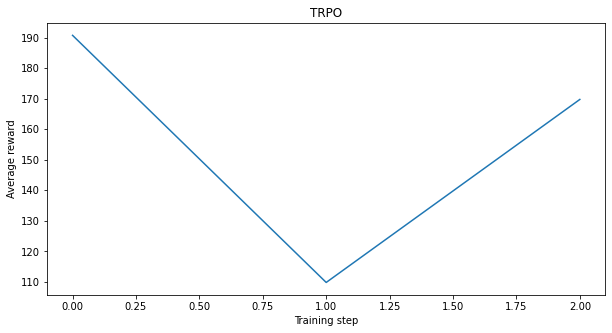

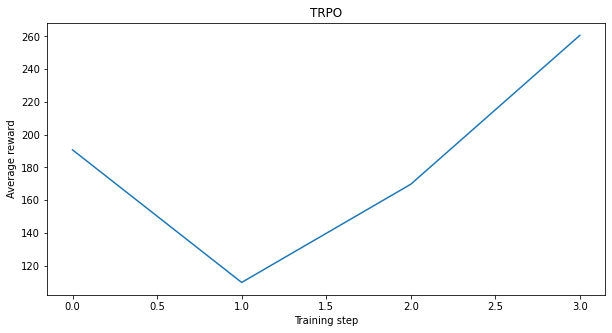

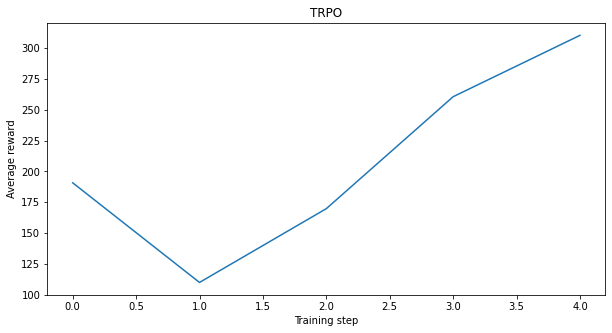

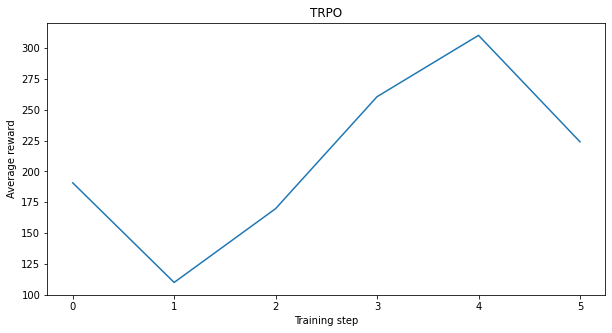

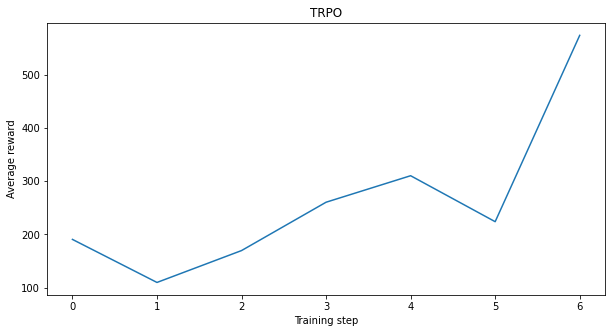

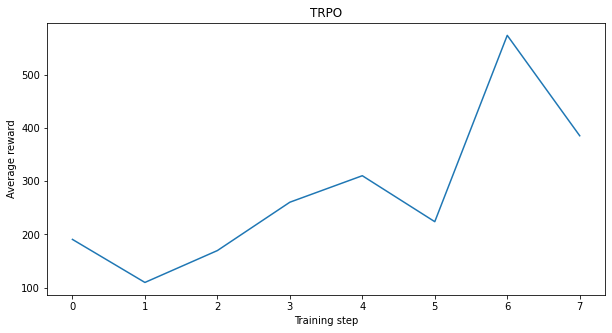

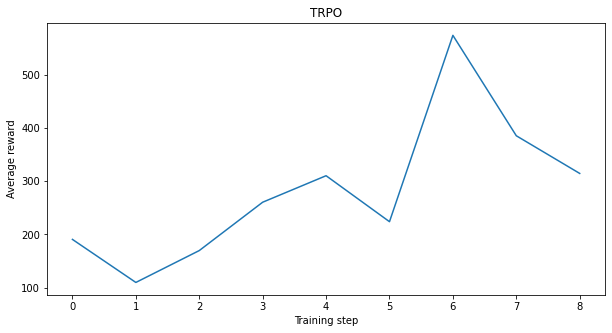

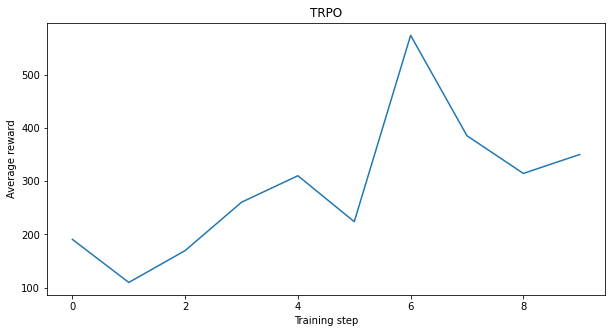

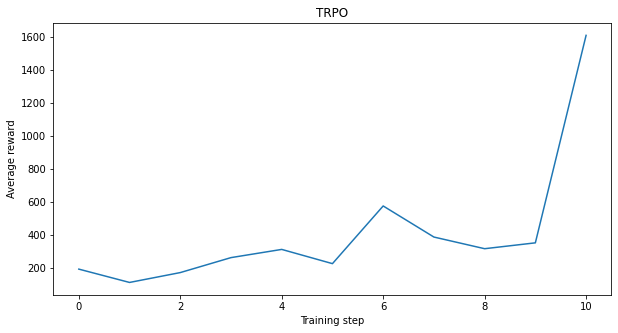

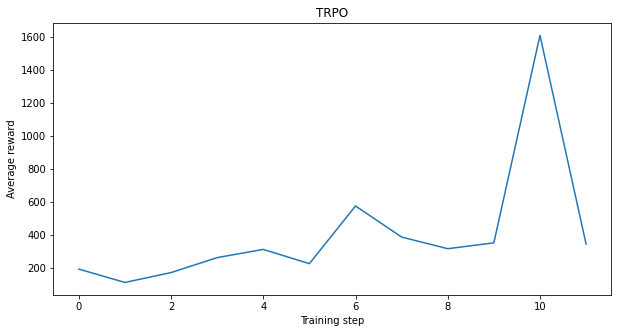

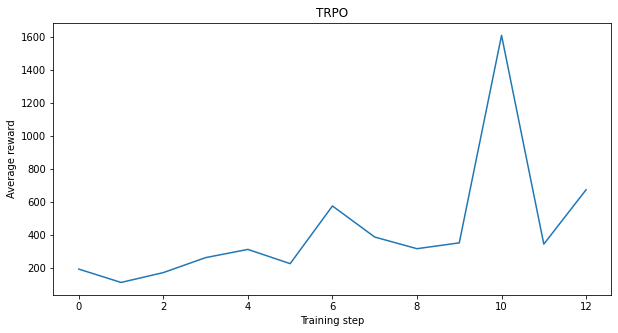

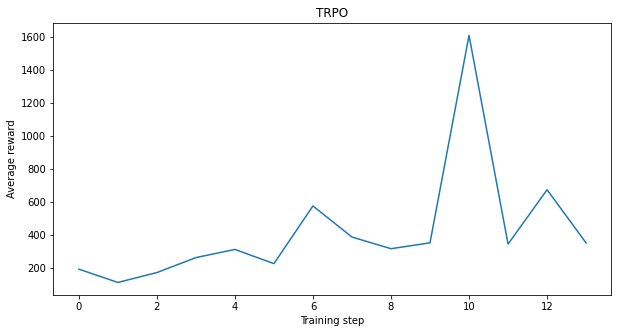

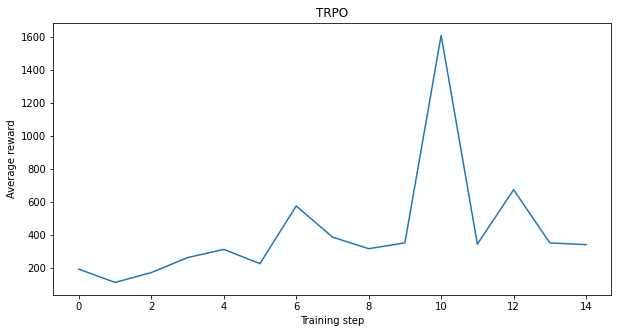

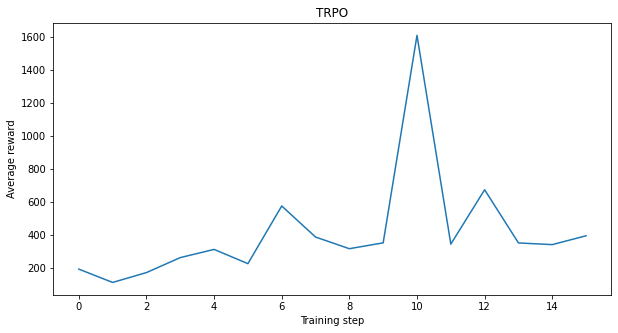

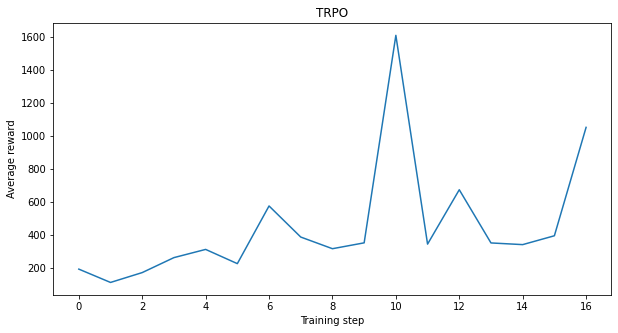

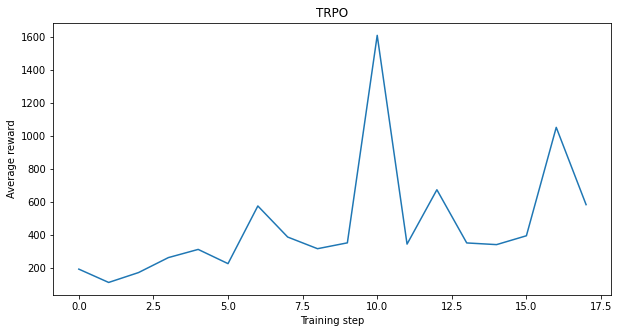

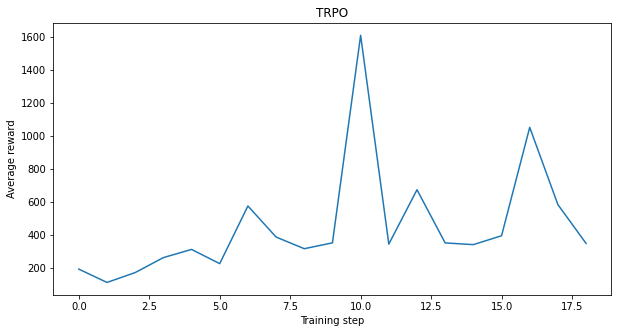

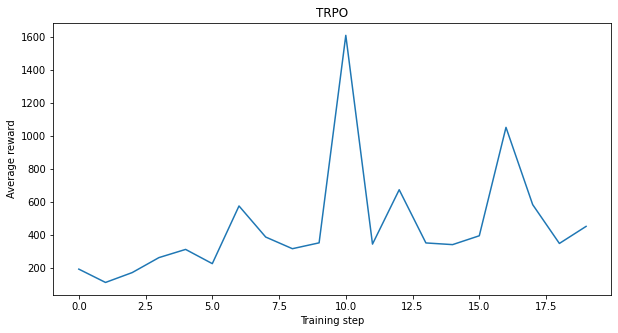

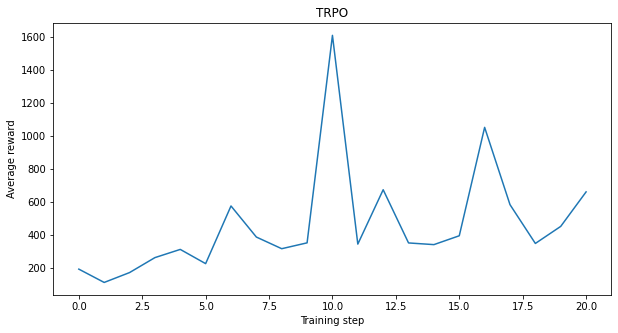

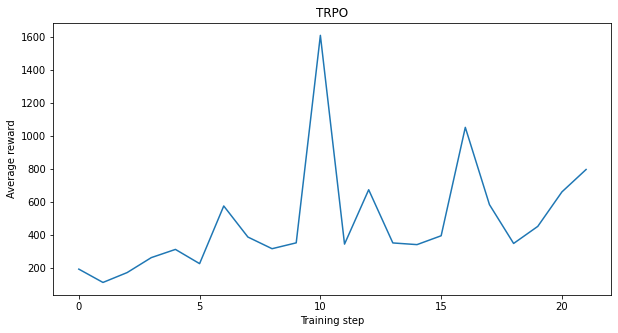

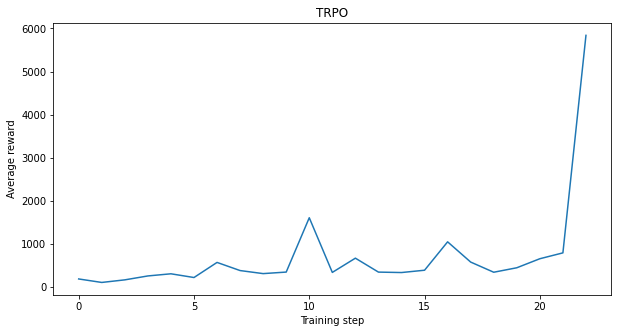

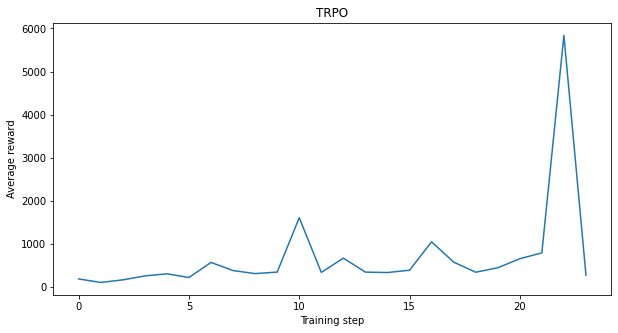

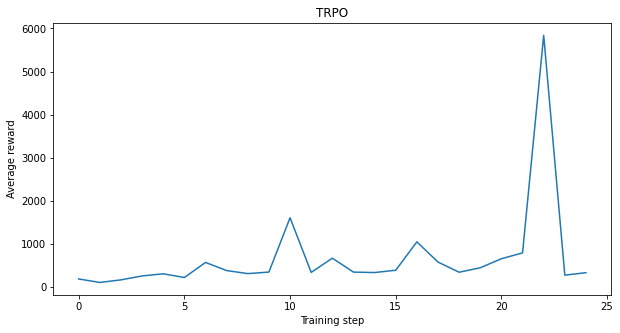

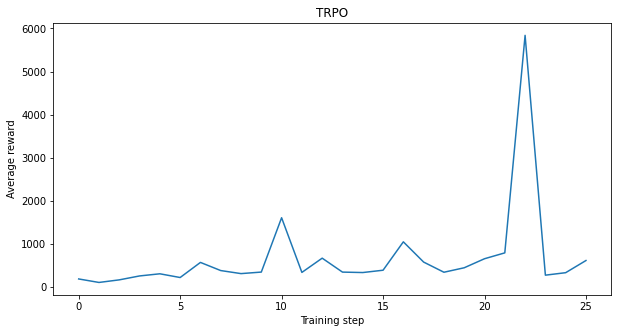

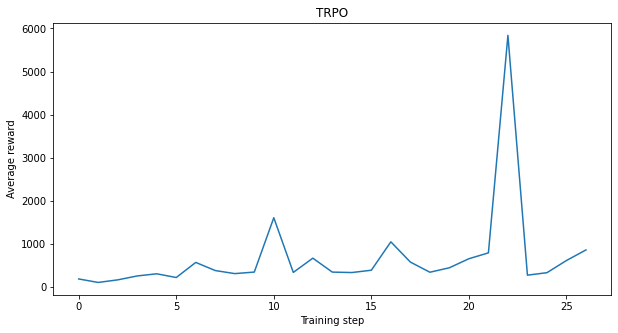

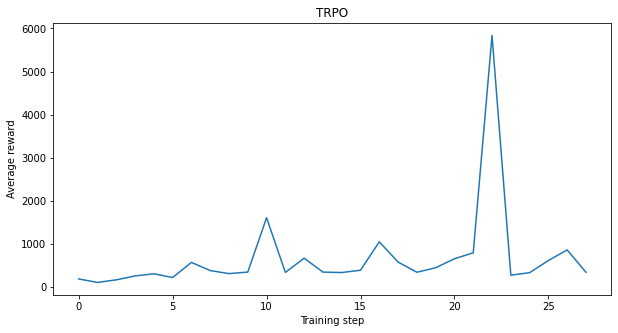

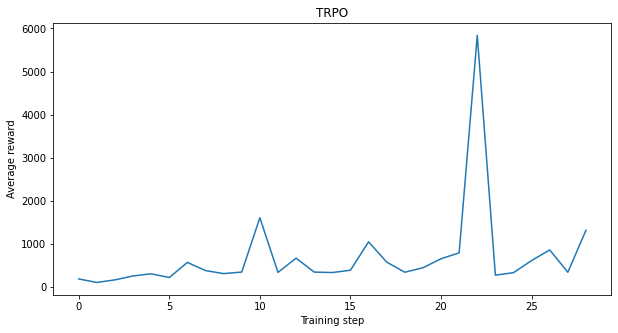

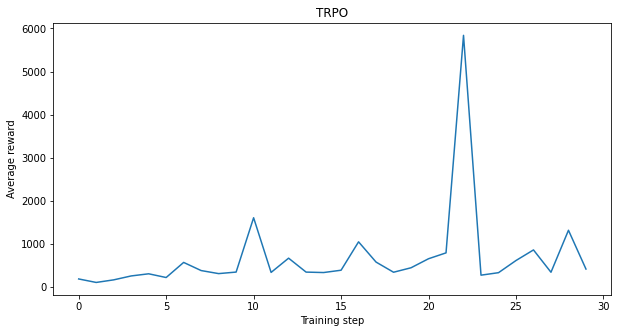

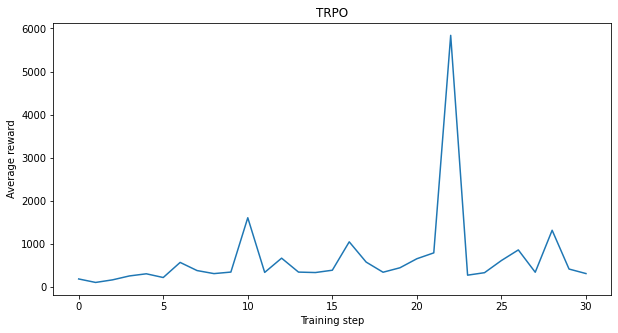

In [13]:
from stable_baselines3 import DQN, A2C, PPO
from sb3_contrib import ARS, TRPO

num_epochs = 30
models = [DQN, A2C, PPO, TRPO]
for model_class in models:
    env = mRubisCliffEnv(Q, P)
    model = model_class('MlpPolicy', env)
    evaluator = Evaluator(model, env, plot_progress=True)
    model.learn(total_timesteps=int(10000*num_epochs), callback=evaluator)
    plt.savefig("results/CTMC2/"+model.__class__.__name__+".png", dpi=600)